In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, Dropout, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt


In [2]:
df = pd.read_csv('/content/drive/MyDrive/Twitter_sentiment.csv', encoding='ISO-8859-1', header=None, names=['target', 'id', 'date', 'flag', 'user', 'text'],)
df = df.sample(n=100000, random_state=42)
df['target'] = df['target'].replace({0: 0, 4: 1})




In [3]:
import re
import string

def preprocess_text(text):
    """
    Preprocesses the input text by removing URLs, special characters, and converting to lowercase.
    """
    # Convert to string if bytes-like object
    if isinstance(text, bytes):
        text = text.decode('utf-8', 'ignore')
    
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    
    # Remove punctuation and special characters
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'[^\x00-\x7F]+', '', text)
    
    # Convert to lowercase
    text = text.lower()
    
    return text

In [4]:
df['text'] = df['text'].apply(preprocess_text)
df.head()


,target,id,date,flag,user,text
541200,0,2200003196,Tue Jun 16 18:18:12 PDT 2009,NO_QUERY,LaLaLindsey0609,chrishasboobs ahhh i hope your ok
750,0,1467998485,Mon Apr 06 23:11:14 PDT 2009,NO_QUERY,sexygrneyes,misstoriblack cool i have no tweet apps for ...
766711,0,2300048954,Tue Jun 23 13:40:11 PDT 2009,NO_QUERY,sammydearr,tiannachaos i know just family drama its lame...
285055,0,1993474027,Mon Jun 01 10:26:07 PDT 2009,NO_QUERY,Lamb_Leanne,school email wont open and i have geography s...
705995,0,2256550904,Sat Jun 20 12:56:51 PDT 2009,NO_QUERY,yogicerdito,upper airways problem


In [5]:
train_size = int(len(df) * 0.8)
train_texts = df['text'][:train_size]
train_labels = df['target'][:train_size]
test_texts = df['text'][train_size:]
test_labels = df['target'][train_size:]

In [6]:
from textblob import TextBlob
from textblob.tokenizers import WordTokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [7]:
import nltk
nltk.download('punkt')
from textblob import TextBlob
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenize train texts
train_sequences = []
for text in train_texts:
    blob = TextBlob(text)
    tokens = blob.words
    train_sequences.append(tokens)

# Tokenize test texts
test_sequences = []
for text in test_texts:
    blob = TextBlob(text)
    tokens = blob.words
    test_sequences.append(tokens)

# Convert tokens to sequences
tokenizer = Tokenizer(num_words=5000, lower=True)
tokenizer.fit_on_texts(train_sequences)

train_data = tokenizer.texts_to_sequences(train_sequences)
test_data = tokenizer.texts_to_sequences(test_sequences)

# Pad sequences
max_len = 100
train_data = pad_sequences(train_data, maxlen=max_len)
test_data = pad_sequences(test_data, maxlen=max_len)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [8]:
input_layer = Input(shape=(100,))
embedding_layer = Embedding(5000, 128, input_length=100)(input_layer)
lstm_layer = LSTM(64, dropout=0.2, recurrent_dropout=0.2)(embedding_layer)
dropout_layer = Dropout(0.5)(lstm_layer)
lr_layer = Dense(1, activation='sigmoid')(dropout_layer)
lr_model = Model(inputs=input_layer, outputs=lr_layer)

lstm_layer_2 = LSTM(64, dropout=0.2, recurrent_dropout=0.2)(embedding_layer)
dropout_layer_2 = Dropout(0.5)(lstm_layer_2)
concat_layer = concatenate([dropout_layer, dropout_layer_2])
lr_layer_2 = Dense(1, activation='sigmoid')(concat_layer)

lstm_layer_3 = LSTM(64, dropout=0.2, recurrent_dropout=0.2)(embedding_layer)
dropout_layer_3 = Dropout(0.5)(lstm_layer_3)
concat_layer = concatenate([dropout_layer, dropout_layer_3])
lr_layer_3 = Dense(1, activation='sigmoid')(concat_layer)
lr_lstm_model = Model(inputs=input_layer, outputs=lr_layer_3)

In [9]:
lr_model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0001), metrics=['accuracy'])
lr_model.fit(train_data, train_labels, validation_split=0.1, epochs=10, batch_size=32)

lr_lstm_model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0001), metrics=['accuracy'])
lr_lstm_model.fit(train_data, train_labels, validation_split=0.1, epochs=10, batch_size=32)


Epoch 1/10
2250/2250 [==============================] - 218s 96ms/step - loss: 0.4995 - accuracy: 0.7581 - val_loss: 0.4584 - val_accuracy: 0.7816
Epoch 2/10
2250/2250 [==============================] - 215s 95ms/step - loss: 0.4322 - accuracy: 0.7990 - val_loss: 0.4609 - val_accuracy: 0.7816
Epoch 3/10
2250/2250 [==============================] - 216s 96ms/step - loss: 0.4008 - accuracy: 0.8155 - val_loss: 0.4613 - val_accuracy: 0.7854
Epoch 4/10
2250/2250 [==============================] - 215s 96ms/step - loss: 0.3743 - accuracy: 0.8284 - val_loss: 0.4966 - val_accuracy: 0.7868
Epoch 5/10
2250/2250 [==============================] - 213s 95ms/step - loss: 0.3519 - accuracy: 0.8399 - val_loss: 0.4996 - val_accuracy: 0.7779
Epoch 6/10
2250/2250 [==============================] - 217s 96ms/step - loss: 0.3272 - accuracy: 0.8511 - val_loss: 0.5504 - val_accuracy: 0.7799
Epoch 7/10
2250/2250 [==============================] - 215s 96ms/step - loss: 0.3071 - accuracy: 0.8619 - val_loss: 0

Epoch 1/10
2250/2250 [==============================] - 411s 182ms/step - loss: 0.2706 - accuracy: 0.8804 - val_loss: 0.6462 - val_accuracy: 0.7651
Epoch 2/10
2250/2250 [==============================] - 409s 182ms/step - loss: 0.2301 - accuracy: 0.9007 - val_loss: 0.7116 - val_accuracy: 0.7638
Epoch 3/10
2250/2250 [==============================] - 412s 183ms/step - loss: 0.2169 - accuracy: 0.9067 - val_loss: 0.7679 - val_accuracy: 0.7644
Epoch 4/10
2250/2250 [==============================] - 408s 181ms/step - loss: 0.2043 - accuracy: 0.9135 - val_loss: 0.8256 - val_accuracy: 0.7644
Epoch 5/10
2250/2250 [==============================] - 409s 182ms/step - loss: 0.1941 - accuracy: 0.9183 - val_loss: 0.8414 - val_accuracy: 0.7602
Epoch 6/10
2250/2250 [==============================] - 409s 182ms/step - loss: 0.1830 - accuracy: 0.9227 - val_loss: 0.8871 - val_accuracy: 0.7566
Epoch 7/10
2250/2250 [==============================] - 409s 182ms/step - loss: 0.1740 - accuracy: 0.9268 - val_

In [10]:
# Define the maximum length of the input sequence
max_len = 100
# Preprocess the input string
input_text = "he is worst player"
preprocessed_text = preprocess_text(input_text)

# Tokenize and pad the input sequence
input_sequence = tokenizer.texts_to_sequences([preprocessed_text])
input_sequence = pad_sequences(input_sequence, maxlen=max_len)

# Make predictions using the lr_model
lr_predictions = lr_model.predict(input_sequence)
lr_predictions = np.round(lr_predictions).flatten()

# Make predictions using the lr_lstm_model
lr_lstm_predictions = lr_lstm_model.predict(input_sequence)
lr_lstm_predictions = np.round(lr_lstm_predictions).flatten()

# Print the predicted sentiment labels
threshold = 0.5
if lr_lstm_predictions >= threshold:
    sentiment="positive"
else:
    sentiment="negative"
#print("lr_model predictions:", lr_predictions)
print("lr_lstm_model predictions:", lr_lstm_predictions)
print("the given input string is ",sentiment)

1/1 [==============================] - 0s 330ms/step
lr_lstm_model predictions: [0.]
the given input string is  negative


In [11]:
# Assuming you have the trained models lr_model and lr_lstm_model

# Predict labels using lr_model
lr_predictions = lr_model.predict(test_data)
lr_predictions = (lr_predictions >= 0.5).astype(int)  # Apply threshold for binary classification

# Predict labels using lr_lstm_model
lr_lstm_predictions = lr_lstm_model.predict(test_data)
lr_lstm_predictions = (lr_lstm_predictions >= 0.5).astype(int)  # Apply threshold for binary classification


625/625 [==============================] - 16s 26ms/step


In [15]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
# Calculate precision
precision_lr = precision_score(test_labels, lr_predictions)
precision_lr_lstm = precision_score(test_labels, lr_lstm_predictions)

# Calculate recall
recall_lr = recall_score(test_labels, lr_predictions)
recall_lr_lstm = recall_score(test_labels, lr_lstm_predictions)

# Calculate F1 score
f1_lr = f1_score(test_labels, lr_predictions)
f1_lr_lstm = f1_score(test_labels, lr_lstm_predictions)

print("Precision (lr_model):", precision_lr)
print("Precision (lr_lstm_model):", precision_lr_lstm)
print("Recall (lr_model):", recall_lr)
print("Recall (lr_lstm_model):", recall_lr_lstm)
print("F1 Score (lr_model):", f1_lr)
print("F1 Score (lr_lstm_model):", f1_lr_lstm)

Precision (lr_model): 0.7570391005870063
Precision (lr_lstm_model): 0.7505179047055341
Recall (lr_model): 0.7566626889419252
Recall (lr_lstm_model): 0.7565632458233891
F1 Score (lr_model): 0.7568508479633959
F1 Score (lr_lstm_model): 0.7535284504531273


Epoch 1/5
2250/2250 [==============================] - 217s 96ms/step - loss: 0.1623 - accuracy: 0.9323 - val_loss: 1.0232 - val_accuracy: 0.7529
Epoch 2/5
2250/2250 [==============================] - 218s 97ms/step - loss: 0.1537 - accuracy: 0.9361 - val_loss: 1.0438 - val_accuracy: 0.7554
Epoch 3/5
2250/2250 [==============================] - 217s 97ms/step - loss: 0.1487 - accuracy: 0.9372 - val_loss: 1.0610 - val_accuracy: 0.7550
Epoch 4/5
2250/2250 [==============================] - 218s 97ms/step - loss: 0.1453 - accuracy: 0.9396 - val_loss: 1.0445 - val_accuracy: 0.7558
Epoch 5/5
2250/2250 [==============================] - 219s 97ms/step - loss: 0.1400 - accuracy: 0.9433 - val_loss: 1.0914 - val_accuracy: 0.7523
Epoch 1/5
2250/2250 [==============================] - 411s 183ms/step - loss: 0.1288 - accuracy: 0.9469 - val_loss: 1.1417 - val_accuracy: 0.7517
Epoch 2/5
2250/2250 [==============================] - 412s 183ms/step - loss: 0.1233 - accuracy: 0.9499 - val_loss: 1.1715

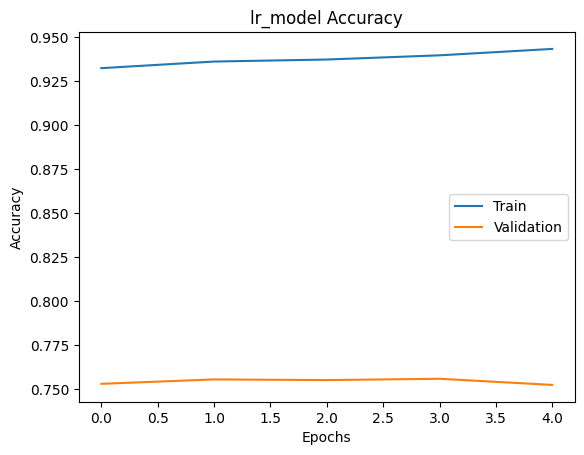

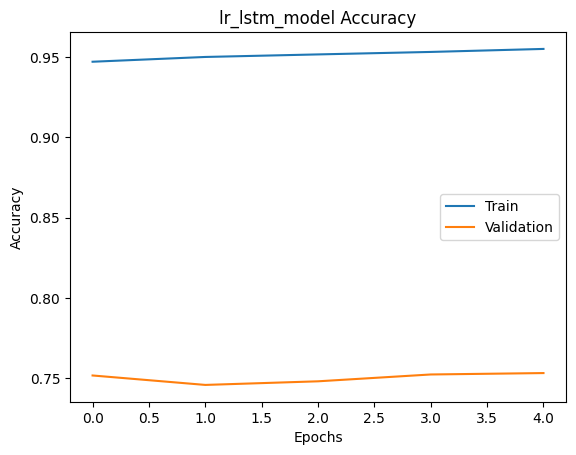

In [17]:
import matplotlib.pyplot as plt

# Train lr_model and store accuracy history
lr_history = lr_model.fit(train_data, train_labels, validation_split=0.1, epochs=5, batch_size=32)

# Train lr_lstm_model and store accuracy history
lr_lstm_history = lr_lstm_model.fit(train_data, train_labels, validation_split=0.1, epochs=5, batch_size=32)

# Plot accuracy over epochs for lr_model
plt.plot(lr_history.history['accuracy'])
plt.plot(lr_history.history['val_accuracy'])
plt.title('lr_model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.show()

# Plot accuracy over epochs for lr_lstm_model
plt.plot(lr_lstm_history.history['accuracy'])
plt.plot(lr_lstm_history.history['val_accuracy'])
plt.title('lr_lstm_model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.show()


In [20]:
from sklearn.metrics import classification_report

# Generate classification report for lr_model
classification_report_lr = classification_report(test_labels, lr_predictions)
print("Classification Report (lr_model):")
print(classification_report_lr)

# Generate classification report for lr_lstm_model
classification_report_lr_lstm = classification_report(test_labels, lr_lstm_predictions)
print("Classification Report (lr_lstm_model):")
print(classification_report_lr_lstm)


Classification Report (lr_model):
              precision    recall  f1-score   support

           0       0.75      0.75      0.75      9944
           1       0.76      0.76      0.76     10056

    accuracy                           0.76     20000
   macro avg       0.76      0.76      0.76     20000
weighted avg       0.76      0.76      0.76     20000

Classification Report (lr_lstm_model):
              precision    recall  f1-score   support

           0       0.75      0.75      0.75      9944
           1       0.75      0.76      0.75     10056

    accuracy                           0.75     20000
   macro avg       0.75      0.75      0.75     20000
weighted avg       0.75      0.75      0.75     20000



In [19]:
# Saving the model
lr_model.save('lr_model.h5')
lr_lstm_model.save('lr_lstm_model.h5')